In [5]:
%cd /Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas

/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas


/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Modelación epidemiológica con SEIR e insumo para el cálculo del exponente de Lyapunov
## Municipio focal: Valledupar, Cesar (2024)

Este cuaderno desarrolla la fase de modelación del proyecto, utilizando como insumo la serie temporal depurada obtenida en el EDA anterior. El propósito central es preparar la información necesaria para calibrar un modelo epidemiológico de tipo SEIR con migración e incidencia no lineal, tomando como foco un municipio con suficiente número de casos: Valledupar, Cesar.

Este cuaderno cumple los siguientes objetivos:

1. Seleccionar el municipio que servirá como base de calibración del modelo.
2. Construir la serie temporal en formato adecuado para el modelo SEIR.
3. Generar la visualización inicial de la serie focal.
4. Exportar el conjunto de datos que será utilizado por el script de calibración y posteriormente para el cálculo del exponente de Lyapunov.

En este cuaderno **no se realiza todavía la calibración**, sino que se dejan listos los insumos que serán utilizados en la etapa siguiente.

## 1. Importación de librerías y carga del conjunto de datos agregado

Se carga el conjunto de datos preparado en la fase anterior (`chagas_prepared.csv`), que contiene la agregación de casos por departamento y municipio, junto con las variables temporales necesarias para construir la serie focal.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

agg_path = "/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas/data/clean/chagas_prepared.csv"
agg = pd.read_csv(agg_path)

agg.head()

,ANO,SEMANA,Fecha,Departamento_residencia,Municipio_residencia,casos
0,2024,1,2024-01-01,ARAUCA,ARAUCA,1
1,2024,1,2024-01-01,ARAUCA,ARAUQUITA,1
2,2024,1,2024-01-01,ARAUCA,FORTUL,1
3,2024,1,2024-01-01,ARAUCA,SARAVENA,4
4,2024,1,2024-01-01,ARAUCA,TAME,1


## 2. Selección del foco epidemiológico para el modelo SEIR

Para calibrar un modelo SEIR es recomendable trabajar con un municipio que presente un número suficiente de casos acumulados, de modo que la dinámica sea representativa y permita identificar parámetros con estabilidad numérica.

A continuación se identifican los municipios con mayor número de casos notificados en 2024 y se selecciona Valledupar (Cesar), dado que es el municipio con el mayor total acumulado.

In [10]:
top_mpios = (
    agg.groupby(["Departamento_residencia", "Municipio_residencia"])["casos"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_mpios

Departamento_residencia  Municipio_residencia
CESAR                    VALLEDUPAR              117
CASANARE                 YOPAL                    65
GUAJIRA                  SAN JUAN DEL CESAR       57
BOYACA                   MONIQUIRA                48
SANTANDER                BUCARAMANGA              40
NORTE SANTANDER          CUCUTA                   27
CASANARE                 AGUAZUL                  24
ARAUCA                   SARAVENA                 21
BOYACA                   CUBARA                   20
BOGOTA                   BOGOTA                   17
Name: casos, dtype: int64

## 3. Filtrado de la serie correspondiente al municipio seleccionado

Se extraen únicamente los registros correspondientes a Valledupar (Cesar). Esta serie será usada como base para la construcción de la dinámica SEIR.

In [11]:
DEP = "CESAR"
MPIO = "VALLEDUPAR"

foco = (
    agg[
        (agg["Departamento_residencia"] == DEP)
        & (agg["Municipio_residencia"] == MPIO)
    ]
    .copy()
    .sort_values(["ANO", "SEMANA"])
)

foco.head()

,ANO,SEMANA,Fecha,Departamento_residencia,Municipio_residencia,casos
10,2024,1,2024-01-01,CESAR,VALLEDUPAR,2
66,2024,4,2024-01-22,CESAR,VALLEDUPAR,1
110,2024,7,2024-02-12,CESAR,VALLEDUPAR,6
132,2024,9,2024-02-26,CESAR,VALLEDUPAR,1
146,2024,10,2024-03-04,CESAR,VALLEDUPAR,1


## 4. Construcción de la serie temporal para el modelo SEIR

El modelo SEIR requiere una serie temporal continua, por lo cual se construye una columna de fecha basada en el año y la semana epidemiológica. Se utiliza el estándar ISO (`%G%V%u`), asignando el lunes de cada semana como fecha representativa.

Se genera la serie ordenada que contendrá únicamente:
- fecha
- año
- semana epidemiológica
- número de casos notificados

In [12]:
foco["fecha"] = pd.to_datetime(
    foco["ANO"].astype(str) + foco["SEMANA"].astype(str) + "1",
    format="%G%V%u",
)

foco_ts = foco[["fecha", "ANO", "SEMANA", "casos"]].sort_values("fecha")
foco_ts.head()

,fecha,ANO,SEMANA,casos
10,2024-01-01,2024,1,2
66,2024-01-22,2024,4,1
110,2024-02-12,2024,7,6
132,2024-02-26,2024,9,1
146,2024-03-04,2024,10,1


## 5. Exportación de la serie temporal focal

La serie temporal generada se exporta como un archivo (`chagas_ts_foco.csv`) que será utilizada por el script de calibración del modelo SEIR. Este archivo constituye el insumo directo para los procedimientos de optimización de parámetros y para el posterior cálculo del exponente de Lyapunov.

## 6. Visualización de la serie temporal focal

La gráfica permite observar la variabilidad de la serie de casos en el tiempo, identificar semanas con incrementos y obtener una primera aproximación de la dinámica que deberá reproducir el modelo SEIR. Los picos, aunque aislados, representan información epidemiológica clave y guiarán la calibración de parámetros sensibles a la transmisión.


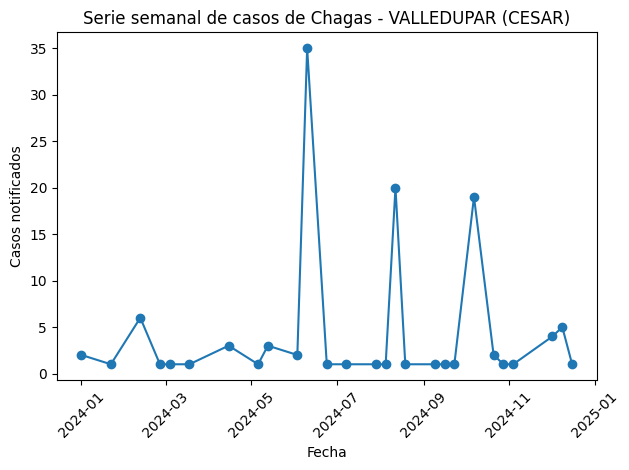

In [13]:
plt.figure()
plt.plot(foco_ts["fecha"], foco_ts["casos"], marker="o")
plt.xlabel("Fecha")
plt.ylabel("Casos notificados")
plt.title(f"Serie semanal de casos de Chagas - {MPIO} ({DEP})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Verificación básica de la serie focal
n_registros = foco_ts.shape[0]
total_casos = foco_ts["casos"].sum()
casos_max = foco_ts["casos"].max()

print(f"Número de registros temporales en Valledupar ({DEP}): {n_registros}")
print(f"Total de casos notificados en el periodo: {total_casos}")
print(f"Máximo número de casos en una semana: {casos_max}")

Número de registros temporales en Valledupar (CESAR): 27
Total de casos notificados en el periodo: 117
Máximo número de casos en una semana: 35


### Verificación de la serie focal

La verificación numérica de la serie temporal de Valledupar permite confirmar que:

- El número de registros temporales es coherente con el periodo analizado.
- El total de casos acumulados coincide con el valor reportado en la tabla de municipios con mayor carga de enfermedad.
- El máximo número de casos registrados en una semana ofrece una referencia inicial sobre la magnitud de los picos que el modelo SEIR deberá ser capaz de reproducir.

Con esta revisión se asegura que la serie focal seleccionada es consistente y adecuada como base para el proceso de calibración.

## 7. Conclusiones del cuaderno de preparación del foco

En este cuaderno se seleccionó y preparó la serie temporal que servirá como insumo para la calibración del modelo SEIR y para el cálculo del exponente de Lyapunov en el municipio de Valledupar, Cesar.

Los principales logros de esta etapa son:

- Identificación de los municipios con mayor número de casos notificados de enfermedad de Chagas en 2024.
- Selección de Valledupar como foco epidemiológico, dado que concentra el mayor número de casos en el periodo estudiado.
- Construcción de una serie temporal ordenada por fecha y semana epidemiológica, con la variable de interés `casos`.
- Exportación de la serie focal en el archivo `data/clean/chagas_ts_foco.csv`, que será utilizado directamente por los scripts de modelación y por el cuaderno de calibración.

La serie obtenida muestra una dinámica de baja incidencia, con episodios de incremento que serán relevantes para la estimación de los parámetros del modelo SEIR. Esta preparación garantiza que la información que alimentará el modelo es consistente, documentada y reproducible dentro del proyecto.

En el siguiente cuaderno se definirá formalmente el modelo SEIR, se implementará el procedimiento de calibración y se analizará el ajuste del modelo frente a la serie observada, sentando las bases para el cálculo del exponente de Lyapunov.